# Cutout with color pairs with 2 stars in multi colors

- author Sylvie Dagoret-Campagne
- creation date 2024-05-08
- last update 2024-06-10
- affiliation : IJCLab
- Kernel **w_2024_16**

- want to see within 30 arcsec from main source thus need box size of 300 pixel

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.patches import Circle,Annulus
from astropy.visualization import ZScaleInterval
props = dict(boxstyle='round', facecolor=None, alpha=0.1)
#props = dict(boxstyle='round')


import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.io import fits
from astropy.wcs import WCS


import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 100)

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle
from collections import OrderedDict

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

import scipy
from scipy.optimize import curve_fit

In [2]:
import gc

In [3]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.time import Time
import scipy

In [4]:
import lsst.daf.butler as dafButler
#import lsst.summit.utils.butlerUtils as butlerUtils

In [5]:
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.afw.display.rgb as afwRgb
import lsst.afw.image as afwImage
import lsst.geom as geom

#import lsst.sphgeom
from  lsst.geom import SpherePoint, Angle
import lsst.sphgeom

In [6]:

from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb
import gc

import lsst.afw.display as afwDisplay
from lsst.afw.image import MultibandExposure

In [7]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [8]:
transform = AsinhStretch() + PercentileInterval(99.)

In [9]:
# INSERT YOUR collection and tract
# for rehearsal use collection 2 which have CCDvisit
butlerRoot = "/repo/embargo"

collection1 = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'
collection2 = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
collection3 = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240414/w_2024_15/PREOPS-5069' # COMPLETED

collectionn = collection
#collections = [collection1,collection2,collection3]
collections = [collection]
collectionStr = collectionn.replace("/", "_")
fn_ccdVisit_tracts_patches = f"ccdVisittractpatch_{collectionStr}.csv"
instrument = 'LATISS'
skymapName = "latiss_v1"
where_clause = "instrument = \'" + instrument+ "\'"
tract = 3864 # mostly for light-curves
patch_sel = 236
#tract = 5615
# tract = 5634 # interesting to view calib parameters
suptitle = collectionStr + f" inst = {instrument} tract = {tract}"

In [10]:
#dataId = {"skymap": "latiss_v1", "tract": 5615, "instrument": "LATISS"}
dataId = {"skymap": skymapName, "tract": tract, "instrument": instrument}
repo = '/sdf/group/rubin/repo/oga/'
butler = dafButler.Butler(repo)
#t = Butler.get(table_sel, dataId=dataId, collections=collections)
registry = butler.registry

In [11]:
skymap_auxtel ='latiss_v1'
skymap = butler.get('skyMap', skymap=skymap_auxtel, collections=collections)

In [12]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

In [13]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

In [14]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4

In [15]:
def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              dataId=coaddId)

    return cutout_image

In [16]:
def cutout_calexp(butler, ra, dec, visit, detector, cutoutSideLength=51, **kwargs):
    
    """
    Produce a cutout from a calexp at the given ra, dec position.

    Adapted from cutout_coadd which was adapted from a DC2 tutorial
    notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    visit: int
        Visit id of the calexp's visit
    detector: int
        Detector for the calexp
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    
    dataId = {'visit': visit, 'detector': detector}    
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)    
    calexp_wcs = butler.get('calexp.wcs', **dataId)
    xy = geom.PointI(calexp_wcs.skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    parameters = {'bbox': bbox}
    cutout_image = butler.get('calexp', parameters=parameters, **dataId)

    return cutout_image

In [17]:
def create_rgb(image, bgr="gri", stretch=1, Q=10, scale=None):
    """
    Create an RGB color composite image.

    Parameters
    ----------
    image : `MultibandExposure`
        `MultibandExposure` to display.
    bgr : sequence
        A 3-element sequence of filter names (i.e., keys of the exps dict)
        indicating what band to use for each channel. If `image` only has
        three filters then this parameter is ignored and the filters
        in the image are used.
    stretch: int
        The linear stretch of the image.
    Q: int
        The Asinh softening parameter.
    scale: list of 3 floats, each less than 1. (default: None)
        Re-scales the RGB channels.

    Returns
    -------
    rgb: ndarray
        RGB (integer, 8-bits per channel) colour image as an NxNx3 numpy array.
    """

    # If the image only has 3 bands, reverse the order of the bands
    #   to produce the RGB image
    if len(image) == 3:
        bgr = image.filters

    # Extract the primary image component of each Exposure with the
    #   .image property, and use .array to get a NumPy array view.

    if scale is None:
        r_im = image[bgr[2]].array  # numpy array for the r channel
        g_im = image[bgr[1]].array  # numpy array for the g channel
        b_im = image[bgr[0]].array  # numpy array for the b channel
    else:
        # manually re-scaling the images here
        r_im = image[bgr[2]].array * scale[0]
        g_im = image[bgr[1]].array * scale[1]
        b_im = image[bgr[0]].array * scale[2]

    rgb = make_lupton_rgb(image_r=r_im,
                          image_g=g_im,
                          image_b=b_im,
                          stretch=stretch, Q=Q)
    # "stretch" and "Q" are parameters to stretch and scale the pixel values

    return rgb

In [18]:
def find_neighbourg(ra0,dec0,src):
    """ 
    """
    all_angles = []
    for index, row in src.iterrows():
        spherePointCenter = lsst.geom.SpherePoint(ra0*lsst.geom.degrees, dec0*lsst.geom.degrees)
        spt = lsst.geom.SpherePoint(row["ra"]*lsst.geom.degrees, row["dec"]*lsst.geom.degrees)
        ang = spherePointCenter.separation(spt)
        ang_arcsec = ang.asArcseconds()
        all_angles.append(ang_arcsec)
    return all_angles

In [19]:
def PlotAndFitHisto(data,std_clip,ax,nbins=50,xlabel=r'$(G-R)_1 - (G-R)_2$ :',title="Differential color with 2 stars",xmin=-100.,xmax=100.):
    #data = df_col_gr["ratio3"].values

    hist, bin_edges = np.histogram(data,bins=nbins,range=(xmin,xmax),density=True)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

    # Define model function to be used to fit to the data above:
    def gauss(x, *p):
        A, mu, sigma = p
        return A*np.exp(-(x-mu)**2/(2.*sigma**2))

    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    p0 = [1., 0., 1.]

    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)

    # Get the fitted curve
    hist_fit = gauss(bin_centres, *coeff)

    textstr = '\n'.join((
    xlabel,
    r'$\sigma_{clipped} = %.01f$ mmag' %(std_clip,),
    r'$\sigma_{fit} = %.01f$ mmag' %(coeff[2], )))

    ax.step(bin_centres, hist,'k' ,label='data')
    ax.plot(bin_centres, hist_fit,'r-', label='fit')
    ax.set_xlabel(xlabel)
    ax.legend()
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=16,verticalalignment='top',color="blue", weight='bold',bbox=props)
    ax.set_title(title)
    ax.set_xlim(xmin,xmax)
    # Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
    #print('Fitted mean = ', coeff[1])
    #print('Fitted standard deviation = ', coeff[2])

## Get Pixel Scale

In [20]:
import lsst.geom as geom
import lsst.sphgeom

skymap = butler.get('skyMap', skymap=skymapName, collections=collections )
tractInfo = skymap.generateTract(tract)
for patch in tractInfo:    
    patchID = patch.getSequentialIndex()
        
    ibb=patch.getInnerBBox()
    tWCS=tractInfo.getWcs()
       
    # loop on the 4 corners
    for icorn,corner in enumerate(ibb.getCorners()):
        p = geom.Point2D(corner.getX(), corner.getY())
        coord = tWCS.pixelToSky(p)

In [21]:
tWCS

FITS standard SkyWcs:
Sky Origin: (122.4365482234, -36.4462809917)
Pixel Origin: (28499, 28499)
Pixel Scale: 0.1 arcsec/pixel

In [22]:
#arcsec/pixel
pixel_scale = tWCS.getPixelScale().asArcseconds()

## Selected visits

In [23]:
#inputfilename = "sources_objectTable-t3864-multibands-o912-LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069.csv"
inputfilename = "sources_objectTable-t3864-multibands-o617-LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069.csv"
df_myselectedvisits = pd.read_csv(inputfilename ,index_col=0)
tract = 3864
#objectname = 547
#objectname = 912
objectname = 617
path = f"calexp_t{tract}_allband_o{objectname}"
title = f"Auxtel Light Curves : tract = {tract}, objectIdx = {objectname} "
suptitle = inputfilename 

In [24]:
if not os.path.exists(path):
    os.mkdir(path)

In [25]:
df_myselectedvisits.sort_values("visit",inplace=True)
#df_myselectedvisits.sort_index(inplace=True)

In [26]:
df_myselectedvisits

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,psfSn,psfMag,psfMagErr,apFlux_35_0_calFlux,apFlux_35_0_calFluxErr,apFlux_35_0_calMag,apFlux_35_0_calMagErr,apFlux_50_0_calFlux,apFlux_50_0_calFluxErr,apFlux_50_0_calMag,apFlux_50_0_calMagErr,psfInstMag,psfInstMagErr,psfGausFluxRatio,ccd_ccdVisitId,ccd_visitId,ccd_band,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,ccd_detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE,dra,ddec,psfMagDiffMmag,psfMagDiffChi,raDiffMas,decDiffMas,raCosDecDiffMas,localPhotoCalibMag,localPhotoCalibMagErr,DZP
27958,178244598085189809,2.968242e+06,11697.085896,False,0.976634,0.0,0.0,True,False,3.014513e+06,14042.247792,False,21.118671,0.040782,False,176,2023111500530,0,122.611125,-36.182900,SDSSg_65mm~empty,g,146033.238175,650.708539,3606.124625,1980.116270,149104.957635,850.607915,False,0.306276,False,176,617,253.759141,15.218752,0.004279,3.084028e+06,13742.099856,15.177204,0.004838,3.148899e+06,17963.709115,15.154603,0.006194,18.530418,0.004279,0.984651,42496823808,2023111500530,g,16.128702,28.093296,5.419498,2.817154,7.537314,0.010960,0.005673,48,0.001052,0.003920,0.018692,0.018995,-0.017123,0.080866,0.014841,0.880911,1676.76050,3.605022,0.034047,10.649044,0.331432,-36.182931,0,1.221441,359.999656,2023-11-16 08:01:48.083009,60264.334584,30.0,2023-11-16 08:01:33.083009,60264.334411,30.2405,4071,3999,122.493156,-36.236782,122.627343,-36.235393,122.625541,-36.129044,122.491536,-36.130431,1.040973,0.004059,0.051731,0.000031,773.376324,25.160907,-9.611629,-0.239499,-8.734651,28.088334,0.002097,-0.004963
7868,178244599158931732,5.202923e+06,17312.295246,False,1.005092,0.0,0.0,True,False,5.145652e+06,20409.697208,False,26.546797,0.041433,False,275,2023111500531,0,122.611126,-36.182899,SDSSr_65mm~empty,r,193970.280456,689.344081,3606.487537,1981.793480,198884.572425,885.595257,False,0.681875,False,275,617,300.533431,14.609381,0.003613,5.149290e+06,18299.877624,14.620632,0.003859,5.279748e+06,23509.717808,14.593467,0.004835,18.169412,0.003613,1.011130,42496824064,2023111500531,r,15.978312,27.848997,4.830028,4.597139,7.679414,0.008806,0.004411,75,-0.001685,0.005047,0.019136,0.022899,0.001455,0.122511,0.025140,1.008064,1304.76370,1.773416,0.042865,6.525798,0.211327,-36.182975,0,1.088479,0.002246,2023-11-16 08:02:34.713010,60264.335124,30.0,2023-11-16 08:02:19.713010,60264.334950,30.2402,4071,3999,122.493148,-36.236816,122.627332,-36.235428,122.625532,-36.129097,122.491530,-36.130483,1.040187,0.005321,0.051741,0.000076,164.006160,5.350652,-4.229930,3.970424,0.927770,27.839970,0.001695,-0.009027
7902,178244600232673685,6.712463e+06,18337.699121,False,0.981708,0.0,0.0,True,False,6.677918e+06,21684.308514,False,24.603605,0.031831,False,404,2023111500532,0,122.611126,-36.182900,empty~SDSSi_65mm,i,277229.037043,765.266500,3597.958361,1981.008598,281294.479399,969.500176,False,0.721356,False,404,617,366.047180,14.332795,0.002966,6.820834e+06,18828.314670,14.315406,0.002997,6.920858e+06,23853.199365,14.299600,0.003742,17.810292,0.002966,1.005173,42496824320,2023111500532,i,15.822762,27.918808,4.619072,11.293973,8.086581,0.007838,0.003896,86,-0.001692,0.007018,0.016011,0.023179,0.005753,0.073651,0

In [27]:
df_myselectedvisits["nightObs"] = df_myselectedvisits.apply(lambda x: x['visit']//100_000 , axis=1)
df_myselectedvisits["Time"] = pd.to_datetime(df_myselectedvisits['obsStart'])

In [28]:
df_myselectedvisits_g = df_myselectedvisits[df_myselectedvisits.band == "g"]
df_myselectedvisits_r = df_myselectedvisits[df_myselectedvisits.band == "r"]
df_myselectedvisits_z = df_myselectedvisits[df_myselectedvisits.band == "z"]
df_myselectedvisits_y = df_myselectedvisits[df_myselectedvisits.band == "y"]

In [29]:
# no 2023112100507 in z
df_myselectedvisits_z[["nightObs","visit"]] 

,nightObs,visit
25973,20231121,2023112100560
26428,20231121,2023112100592
40708,20231127,2023112700311
20984,20231127,2023112700359
53980,20231128,2023112800542
54818,20231128,2023112800577
74263,20231129,2023112900595
37676,20231204,2023120400591
37795,20231204,2023120400595
51442,20231205,2023120500491


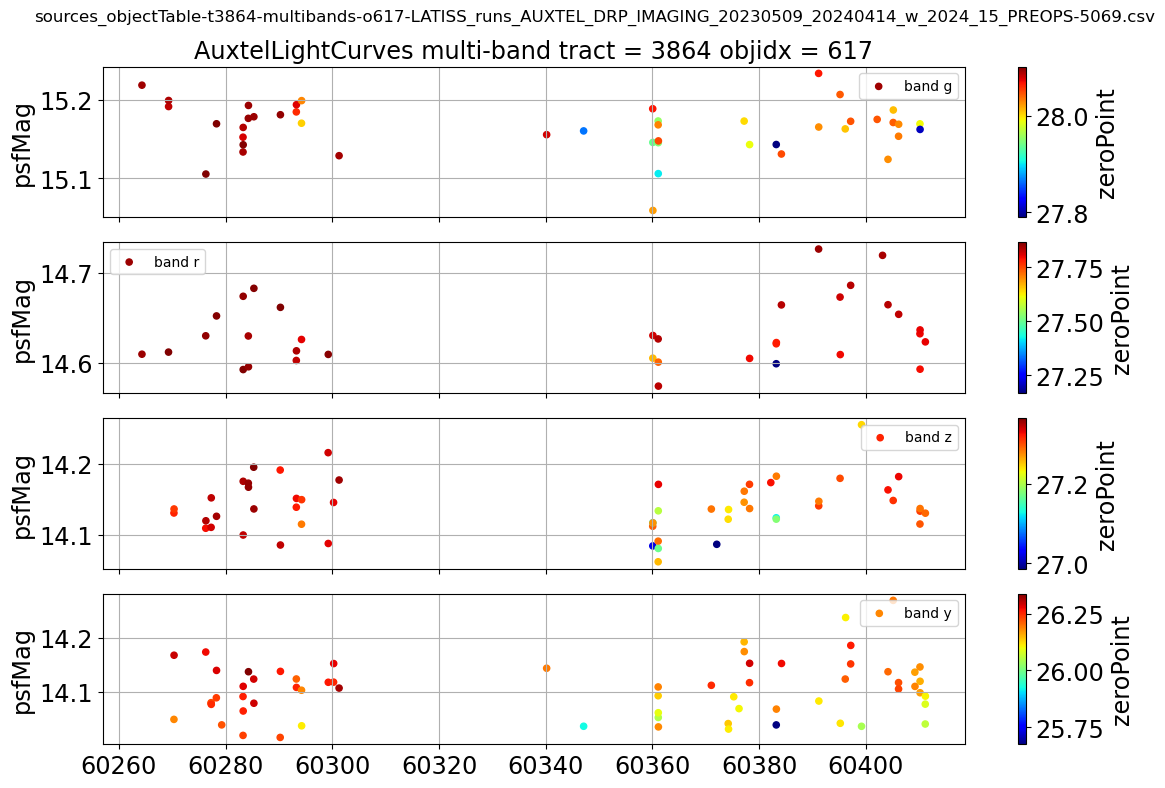

In [30]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(12,8),sharex=True)
title = f"AuxtelLightCurves multi-band tract = {tract} objidx = {objectname}"
df_myselectedvisits_g.plot.scatter(x="expMidptMJD",y="psfMag",ax=ax1,s=20,c="zeroPoint",cmap="jet",label="band g",grid=True,rot=45)
ax1.set_title(title)
df_myselectedvisits_r.plot.scatter(x="expMidptMJD",y="psfMag",ax=ax2,s=20,c="zeroPoint",cmap="jet",label="band r",grid=True,rot=45)
df_myselectedvisits_z.plot.scatter(x="expMidptMJD",y="psfMag",ax=ax3,s=20,c="zeroPoint",cmap="jet",label="band z",grid=True,rot=45)
df_myselectedvisits_y.plot.scatter(x="expMidptMJD",y="psfMag",ax=ax4,s=20,c="zeroPoint",cmap="jet",label="band y",grid=True,rot=45)
#plt.setp(ax1.get_xticklabels(), visible=False)
#plt.setp(ax2.get_xticklabels(), visible=False)
#plt.setp(ax3.get_xticklabels(), visible=False)
#plt.setp(ax4.get_xticklabels(), visible=True)
ax4.tick_params(labelbottom=True)
plt.suptitle(suptitle)
plt.tight_layout()
plt.show()

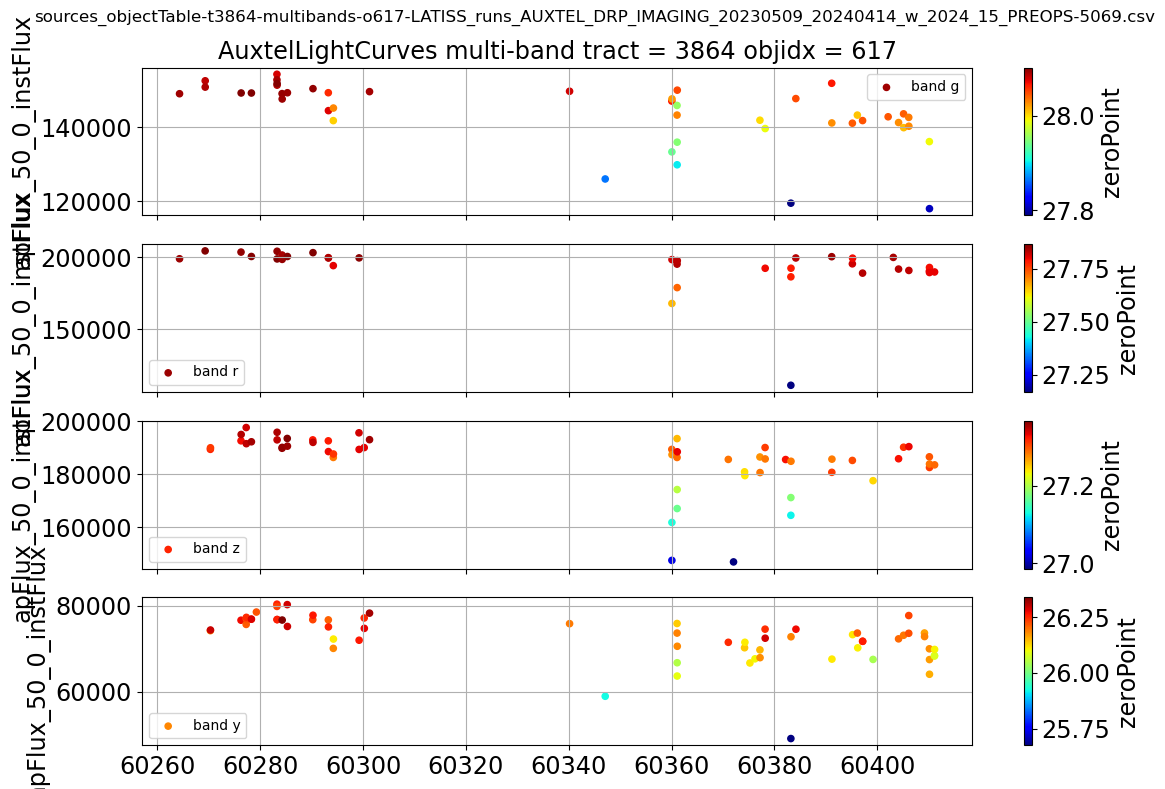

In [31]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(12,8),sharex=True)
title = f"AuxtelLightCurves multi-band tract = {tract} objidx = {objectname}"
df_myselectedvisits_g.plot.scatter(x="expMidptMJD",y="apFlux_50_0_instFlux",ax=ax1,s=20,c="zeroPoint",cmap="jet",label="band g",grid=True,rot=45)
ax1.set_title(title)
df_myselectedvisits_r.plot.scatter(x="expMidptMJD",y="apFlux_50_0_instFlux",ax=ax2,s=20,c="zeroPoint",cmap="jet",label="band r",grid=True,rot=45)
df_myselectedvisits_z.plot.scatter(x="expMidptMJD",y="apFlux_50_0_instFlux",ax=ax3,s=20,c="zeroPoint",cmap="jet",label="band z",grid=True,rot=45)
df_myselectedvisits_y.plot.scatter(x="expMidptMJD",y="apFlux_50_0_instFlux",ax=ax4,s=20,c="zeroPoint",cmap="jet",label="band y",grid=True,rot=45)
#plt.setp(ax1.get_xticklabels(), visible=False)
#plt.setp(ax2.get_xticklabels(), visible=False)
#plt.setp(ax3.get_xticklabels(), visible=False)
#plt.setp(ax4.get_xticklabels(), visible=True)
ax4.tick_params(labelbottom=True)
plt.suptitle(suptitle)
plt.tight_layout()
plt.show()

In [32]:
groups_obs_size = df_myselectedvisits.groupby(by=["nightObs","band"]).size()

In [33]:
groups_obs_size

nightObs  band
20231115  g       1
          i       2
          r       1
20231120  g       2
          r       1
                 ..
20240409  y       3
          z       3
20240410  r       1
          y       3
          z       1
Length: 119, dtype: int64

In [34]:
df_groups_obs_size = groups_obs_size.unstack()
df_groups_obs_size

band,g,i,r,y,z
nightObs,,,,,
20231115,1.0,2.0,1.0,NaN,NaN
20231120,2.0,NaN,1.0,NaN,NaN
20231121,NaN,NaN,NaN,2.0,2.0
20231127,1.0,NaN,1.0,1.0,2.0
20231128,NaN,NaN,NaN,3.0,2.0
20231129,1.0,NaN,1.0,2.0,1.0
20231130,NaN,NaN,NaN,1.0,NaN
20231204,4.0,NaN,2.0,4.0,2.0
20231205,2.0,NaN,2.0,1.0,2.0


In [35]:
#groups_obs_visit = df_myselectedvisits.groupby(by=["nightObs","band","visit"]).mean()["psfMag"]
#groups_obs_visit 

In [36]:
groups_obs_visit = df_myselectedvisits.groupby(by=["nightObs","band","visit"]).agg(time = ("Time","mean") ,psfMean = ("psfMag","mean"),apFlux_50_0_instFlux = ("apFlux_50_0_instFlux","mean"))
groups_obs_visit 

time    psfMean  \
nightObs band visit                                                    
20231115 g    2023111500530 2023-11-16 08:01:33.083009024  15.218752   
         i    2023111500532 2023-11-16 08:03:08.078509056  14.332795   
              2023111500556 2023-11-16 08:27:38.305004032  14.346466   
         r    2023111500531 2023-11-16 08:02:19.713009920  14.609381   
20231120 g    2023112000340 2023-11-21 07:50:37.621999104  15.191494   
...                                                   ...        ...   
20240410 r    2024041000487 2024-04-11 03:26:58.162992896  14.623097   
         y    2024041000457 2024-04-11 02:56:50.417509888  14.040488   
              2024041000461 2024-04-11 03:00:45.103506944  14.077299   
              2024041000493 2024-04-11 03:32:34.718995968  14.092128   
         z    2024041000492 2024-04-11 03:31:46.322509056  14.130497   

                             apFlux_50_0_instFlux  
nightObs band visit                                
20231115 g    2023111500530         149104.957635  
         i    2023111500532         281294.479399  
              2023111500556         280029.884648  
         r    2023111500531         198884.572425  
20231120 g    2023112000340         152606.338448  
...                                           ...  
20240410 r    2024041000487         189726.687497  
         y    2024041000457          68364.255671  
              2024041000461          68252.089254  
              2024041000493          69791.006923  
         z    2024041000492         183584.983861  

[201 rows x 3 columns]

In [37]:
#groups_obs_visit.index

In [38]:
#groups_obs_visit.query('"nightObs" == 20231121  & "band" == "z"')

In [39]:
#groups_obs_visit.loc[(20231121,'z',2023112100516)] 

In [40]:
groups_obs_bandg_visit = df_myselectedvisits_g.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))
groups_obs_bandr_visit = df_myselectedvisits_r.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))
groups_obs_bandz_visit = df_myselectedvisits_z.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))
groups_obs_bandy_visit = df_myselectedvisits_y.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))

In [41]:
groups_obs_bandz_visit.iloc[:5]

time
nightObs visit                                      
20231121 2023112100560 2023-11-22 07:53:58.364506880
         2023112100592 2023-11-22 08:24:23.640499968
20231127 2023112700311 2023-11-28 06:56:06.837505024
         2023112700359 2023-11-28 07:37:57.146994944
20231128 2023112800542 2023-11-29 07:06:26.619001088

## Process night-per night, band by band

We want to associate pairs of observation in different bands:

- visits in g with visits in r,z,y
- visits in r with visits in z,y
- visits in z with visits in y

In [42]:
def closestvisit(df1,df2):
    """
    This function associate pairs of closest observation

    input : the 2 dataframes (first to one for which one want to find the closest obs in dtaframe 2)
    output : the dataframe of similar format as the first one having columns on nightobs , visit time, dt from second dataframe)
    """
    d1 =df1.copy(deep=True)
    d2 =df2.copy(deep=True)
    all_samples = []
    df = pd.DataFrame(index=d1.index,columns=["nightObs2","visit2","time2","deltat"])
    for key in d1.index:
        time1 = d1.loc[key]["time"]
        d2["dt"] = np.abs(d2["time"]-time1)
        d2["Dt"] = d2["time"]-time1
        cut_sel = d2["dt"] == d2["dt"].min()
        sample = d2[cut_sel]
        #df.iloc[key] = [sample.index[0][0],sample.index[0][1],sample["time"].values[0],sample['dt'].values[0]]
        df.loc[key]["nightObs2"] = sample.index[0][0]
        df.loc[key]["visit2"] = sample.index[0][1]
        df.loc[key]["time2"] = sample["time"].values[0]
        df.loc[key]["deltat"] = pd.to_timedelta(sample["Dt"].values[0], unit="s").total_seconds()
        all_samples.append(sample)
    return df

### process band g and r

In [43]:
dfg_r = closestvisit(groups_obs_bandg_visit,groups_obs_bandr_visit)
#dfg_r.drop(labels="deltat", axis=1,inplace=True)
dfg_r.columns = ["nightObs_r","visit_r","time_r","dtsec_r"]

In [44]:
groups_obs_bandg_visit.join(dfg_r).head()

time nightObs_r  \
nightObs visit                                                    
20231115 2023111500530 2023-11-16 08:01:33.083009024   20231115   
20231120 2023112000340 2023-11-21 07:50:37.621999104   20231120   
         2023112000343 2023-11-21 07:53:42.037505024   20231120   
20231127 2023112700353 2023-11-28 07:32:33.813998080   20231127   
20231129 2023112900593 2023-11-30 07:23:20.256995072   20231129   

                              visit_r                         time_r  \
nightObs visit                                                         
20231115 2023111500530  2023111500531  2023-11-16T08:02:19.713009920   
20231120 2023112000340  2023112000320  2023-11-21T07:29:44.874492928   
         2023112000343  2023112000320  2023-11-21T07:29:44.874492928   
20231127 2023112700353  2023112700310  2023-11-28T06:55:20.319507968   
20231129 2023112900593  2023112900594  2023-11-30T07:24:07.003998976   

                            dtsec_r  
nightObs visit                       
20231115 2023111500530        46.63  
20231120 2023112000340 -1252.747507  
         2023112000343 -1437.163013  
20231127 2023112700353 -2233.494491  
20231129 2023112900593    46.747003

### process band g and z

In [45]:
dfg_z = closestvisit(groups_obs_bandg_visit,groups_obs_bandz_visit)
#dfg_z.drop(labels="deltat", axis=1,inplace=True)
dfg_z.columns = ["nightObs_z","visit_z","time_z","dtsec_z"]

In [46]:
dfg_z.head()

nightObs_z        visit_z  \
nightObs visit                                     
20231115 2023111500530   20231121  2023112100560   
20231120 2023112000340   20231121  2023112100560   
         2023112000343   20231121  2023112100560   
20231127 2023112700353   20231127  2023112700359   
20231129 2023112900593   20231129  2023112900595   

                                               time_z        dtsec_z  
nightObs visit                                                        
20231115 2023111500530  2023-11-22T07:53:58.364506880  517945.281497  
20231120 2023112000340  2023-11-22T07:53:58.364506880   86600.742507  
         2023112000343  2023-11-22T07:53:58.364506880   86416.327001  
20231127 2023112700353  2023-11-28T07:37:57.146994944     323.332996  
20231129 2023112900593  2023-11-30T07:24:53.671993088      93.414998

### process band g and y

In [47]:
dfg_y = closestvisit(groups_obs_bandg_visit,groups_obs_bandy_visit)
#dfg_y.drop(labels="deltat", axis=1,inplace=True)
dfg_y.columns = ["nightObs_y","visit_y","time_y","dtsec_y"]

In [48]:
dfg_y.head()

nightObs_y        visit_y  \
nightObs visit                                     
20231115 2023111500530   20231121  2023112100561   
20231120 2023112000340   20231121  2023112100561   
         2023112000343   20231121  2023112100561   
20231127 2023112700353   20231127  2023112700312   
20231129 2023112900593   20231129  2023112900596   

                                               time_y        dtsec_y  
nightObs visit                                                        
20231115 2023111500530  2023-11-22T07:54:46.442998016  517993.359988  
20231120 2023112000340  2023-11-22T07:54:46.442998016   86648.820998  
         2023112000343  2023-11-22T07:54:46.442998016   86464.405492  
20231127 2023112700353  2023-11-28T06:56:55.432996096   -2138.381002  
20231129 2023112900593  2023-11-30T07:25:42.129992960     141.872997

### Concatenation g with r,z,y

In [49]:
dfg_rzy = pd.concat([groups_obs_bandg_visit,dfg_r,dfg_z,dfg_y],axis=1)

In [50]:
dfg_rzy.head() 

time nightObs_r  \
nightObs visit                                                    
20231115 2023111500530 2023-11-16 08:01:33.083009024   20231115   
20231120 2023112000340 2023-11-21 07:50:37.621999104   20231120   
         2023112000343 2023-11-21 07:53:42.037505024   20231120   
20231127 2023112700353 2023-11-28 07:32:33.813998080   20231127   
20231129 2023112900593 2023-11-30 07:23:20.256995072   20231129   

                              visit_r                         time_r  \
nightObs visit                                                         
20231115 2023111500530  2023111500531  2023-11-16T08:02:19.713009920   
20231120 2023112000340  2023112000320  2023-11-21T07:29:44.874492928   
         2023112000343  2023112000320  2023-11-21T07:29:44.874492928   
20231127 2023112700353  2023112700310  2023-11-28T06:55:20.319507968   
20231129 2023112900593  2023112900594  2023-11-30T07:24:07.003998976   

                            dtsec_r nightObs_z        visit_z  \
nightObs visit                                                  
20231115 2023111500530        46.63   20231121  2023112100560   
20231120 2023112000340 -1252.747507   20231121  2023112100560   
         2023112000343 -1437.163013   20231121  2023112100560   
20231127 2023112700353 -2233.494491   20231127  2023112700359   
20231129 2023112900593    46.747003   20231129  2023112900595   

                                               time_z        dtsec_z  \
nightObs visit                                                         
20231115 2023111500530  2023-11-22T07:53:58.364506880  517945.281497   
20231120 2023112000340  2023-11-22T07:53:58.364506880   86600.742507   
         2023112000343  2023-11-22T07:53:58.364506880   86416.327001   
20231127 2023112700353  2023-11-28T07:37:57.146994944     323.332996   
20231129 2023112900593  2023-11-30T07:24:53.671993088      93.414998   

                       nightObs_y        visit_y  \
nightObs visit                                     
20231115 2023111500530   20231121  2023112100561   
20231120 2023112000340   20231121  2023112100561   
         2023112000343   20231121  2023112100561   
20231127 2023112700353   20231127  2023112700312   
20231129 2023112900593   20231129  2023112900596   

                                               time_y        dtsec_y  
nightObs visit                                                        
20231115 2023111500530  2023-11-22T07:54:46.442998016  517993.359988  
20231120 2023112000340  2023-11-22T07:54:46.442998016   86648.820998  
         2023112000343  2023-11-22T07:54:46.442998016   86464.405492  
20231127 2023112700353  2023-11-28T06:56:55.432996096   -2138.381002  
20231129 2023112900593  2023-11-30T07:25:42.129992960     141.872997

### process band r and z

In [51]:
dfr_z = closestvisit(groups_obs_bandr_visit,groups_obs_bandz_visit)
#dfr_z.drop(labels="deltat", axis=1,inplace=True)
dfr_z.columns = ["nightObs_z","visit_z","time_z","dtsec_z"]

In [52]:
dfr_z

nightObs_z        visit_z  \
nightObs visit                                     
20231115 2023111500531   20231121  2023112100560   
20231120 2023112000320   20231121  2023112100560   
20231127 2023112700310   20231127  2023112700311   
20231129 2023112900594   20231129  2023112900595   
20231204 2023120400590   20231204  2023120400591   
         2023120400594   20231204  2023120400595   
20231205 2023120500490   20231205  2023120500491   
         2023120500522   20231205  2023120500523   
20231206 2023120600316   20231206  2023120600317   
20231211 2023121100544   20231211  2023121100545   
20231214 2023121400287   20231214  2023121400288   
         2023121400319   20231214  2023121400320   
20231215 2023121500477   20231215  2023121500478   
20231220 2023122000242   20231220  2023122000243   
20240219 2024021900305   20240219  2024021900306   
         2024021900329   20240219  2024021900330   
20240220 2024022000288   20240220  2024022000289   
         2024022000320   20240220  2024022000321   
         2024022000352   20240220  2024022000353   
20240308 2024030800516   20240308  2024030800517   
20240313 2024031300170   20240313  2024031300171   
         2024031300174   20240313  2024031300175   
         2024031300206   20240313  2024031300207   
20240314 2024031400158   20240313  2024031300207   
20240321 2024032100166   20240321  2024032100199   
20240325 2024032500195   20240325  2024032500196   
         2024032500255   20240325  2024032500196   
20240327 2024032700365   20240325  2024032500196   
20240402 2024040200445   20240403  2024040300475   
20240403 2024040300474   20240403  2024040300475   
20240405 2024040500182   20240405  2024040500183   
20240409 2024040900495   20240409  2024040900496   
         2024040900523   20240409  2024040900524   
         2024040900527   20240409  2024040900528   
20240410 2024041000487   20240410  2024041000492   

                                               time_z        dtsec_z  
nightObs visit                                                        
20231115 2023111500531  2023-11-22T07:53:58.364506880  517898.651496  
20231120 2023112000320  2023-11-22T07:53:58.364506880   87853.490013  
20231127 2023112700310  2023-11-28T06:56:06.837505024      46.517997  
20231129 2023112900594  2023-11-30T07:24:53.671993088      46.667994  
20231204 2023120400590  2023-12-05T07:20:08.551995904      46.701504  
         2023120400594  2023-12-05T07:23:56.250501120      46.698007  
20231205 2023120500490  2023-12-06T06:28:51.514996992      46.642995  
         2023120500522  2023-12-06T07:05:10.501996032      46.611494  
20231206 2023120600316  2023-12-07T07:28:40.619497984      46.792004  
20231211 2023121100544  2023-12-12T06:47:30.575496960      46.754994  
20231214 2023121400287  2023-12-15T06:20:53.768989952      46.780992  
         2023121400319  2023-12-15T06:51:20.173006080      46.728502  
20231215 2023121500477  2023-12-16T05:38:51.498993920      46.798984  
20231220 2023122000242  2023-12-21T06:00:21.419494912      46.804491  
20240219 2024021900305  2024-02-20T01:40:20.153004032      46.627996  
         2024021900329  2024-02-20T02:04:35.811990016      46.821982  
20240220 2024022000288  2024-02-21T01:44:23.228508928      46.714508  
         2024022000320  2024-02-21T02:15:04.462508032       46.78701  
         2024022000352  2024-02-21T02:45:28.101999104      47.068996  
20240308 2024030800516  2024-03-09T04:59:12.180004096      46.880508  
20240313 2024031300170  2024-03-14T04:46:29.336998912      46.728502  
         2024031300174  2024-03-14T04:50:23.674990080      46.656489  
         2024031300206  2024-03-14T05:22:16.174991872      46.712986  
20240314 2024031400158  2024-03-14T05:22:16.174991872    -81314.4215  
20240321 2024032100166  2024-03-22T03:53:04.085490944     1871.08749  
20240325 2024032500195  2024-03-26T03:48:45.377998080      46.854508  
         2024032500255  2024-03-26T03:48:45.377998080   -3519.744507  
20240327 2024032700365  2024-03-26T03:4

### process band r and y

In [53]:
dfr_y = closestvisit(groups_obs_bandr_visit,groups_obs_bandy_visit)
#dfr_y.drop(labels="deltat", axis=1,inplace=True)
dfr_y.columns = ["nightObs_y","visit_y","time_y","dtsec_y"]

In [54]:
dfr_y

nightObs_y        visit_y  \
nightObs visit                                     
20231115 2023111500531   20231121  2023112100561   
20231120 2023112000320   20231121  2023112100561   
20231127 2023112700310   20231127  2023112700312   
20231129 2023112900594   20231129  2023112900596   
20231204 2023120400590   20231204  2023120400592   
         2023120400594   20231204  2023120400596   
20231205 2023120500490   20231205  2023120500524   
         2023120500522   20231205  2023120500524   
20231206 2023120600316   20231206  2023120600318   
20231211 2023121100544   20231211  2023121100546   
20231214 2023121400287   20231214  2023121400289   
         2023121400319   20231214  2023121400321   
20231215 2023121500477   20231215  2023121500479   
20231220 2023122000242   20231220  2023122000244   
20240219 2024021900305   20240220  2024022000286   
         2024021900329   20240220  2024022000286   
20240220 2024022000288   20240220  2024022000290   
         2024022000320   20240220  2024022000322   
         2024022000352   20240220  2024022000354   
20240308 2024030800516   20240308  2024030800518   
20240313 2024031300170   20240313  2024031300176   
         2024031300174   20240313  2024031300176   
         2024031300206   20240313  2024031300208   
20240314 2024031400158   20240314  2024031400192   
20240321 2024032100166   20240321  2024032100232   
20240325 2024032500195   20240325  2024032500257   
         2024032500255   20240325  2024032500257   
20240327 2024032700365   20240327  2024032700367   
20240402 2024040200445   20240403  2024040300476   
20240403 2024040300474   20240403  2024040300476   
20240405 2024040500182   20240405  2024040500152   
20240409 2024040900495   20240409  2024040900497   
         2024040900523   20240409  2024040900525   
         2024040900527   20240409  2024040900529   
20240410 2024041000487   20240410  2024041000493   

                                               time_y        dtsec_y  
nightObs visit                                                        
20231115 2023111500531  2023-11-22T07:54:46.442998016  517946.729988  
20231120 2023112000320  2023-11-22T07:54:46.442998016   87901.568505  
20231127 2023112700310  2023-11-28T06:56:55.432996096      95.113488  
20231129 2023112900594  2023-11-30T07:25:42.129992960      95.125993  
20231204 2023120400590  2023-12-05T07:20:56.460508928      94.610017  
         2023120400594  2023-12-05T07:24:44.167500032      94.615005  
20231205 2023120500490  2023-12-06T07:05:58.444504064    2273.572503  
         2023120500522  2023-12-06T07:05:58.444504064      94.554002  
20231206 2023120600316  2023-12-07T07:29:28.912500992      95.085007  
20231211 2023121100544  2023-12-12T06:48:18.383994112      94.563492  
20231214 2023121400287  2023-12-15T06:21:42.121995008      95.133997  
         2023121400319  2023-12-15T06:52:08.237990912      94.793486  
20231215 2023121500477  2023-12-16T05:39:39.816008960         95.116  
20231220 2023122000242  2023-12-21T06:01:09.469505024      94.854501  
20240219 2024021900305  2024-02-21T01:41:19.567502080   86506.042494  
         2024021900329  2024-02-21T01:41:19.567502080   85050.577495  
20240220 2024022000288  2024-02-21T01:45:11.354504960      94.840504  
         2024022000320  2024-02-21T02:15:52.842497024      95.166999  
         2024022000352  2024-02-21T02:46:16.434493952       95.40149  
20240308 2024030800516  2024-03-09T05:00:00.571990016      95.272494  
20240313 2024031300170  2024-03-14T04:51:12.270996992       329.6625  
         2024031300174  2024-03-14T04:51:12.270996992      95.252496  
         2024031300206  2024-03-14T05:23:04.162504960      94.700499  
20240314 2024031400158  2024-03-15T04:29:32.002496000    1921.406004  
20240321 2024032100166  2024-03-22T04:24:51.128502016    3778.130501  
20240325 2024032500195  2024-03-26T04:48:59.786992896    3661.263502  
         2024032500255  2024-03-26T04:48:59.786992896      94.664487  
20240327 2024032700365  2024-03-28T03:2

### Concatenation of r with z,y

In [55]:
dfr_zy = pd.concat([groups_obs_bandr_visit,dfr_z,dfr_y],axis=1)

In [56]:
dfr_zy.head()

,,time,nightObs_z,visit_z,time_z,dtsec_z,nightObs_y,visit_y,time_y,dtsec_y
nightObs,visit,,,,,,,,,
20231115,2023111500531,2023-11-16 08:02:19.713009920,20231121,2023112100560,2023-11-22T07:53:58.364506880,517898.651496,20231121,2023112100561,2023-11-22T07:54:46.442998016,517946.729988
20231120,2023112000320,2023-11-21 07:29:44.874492928,20231121,2023112100560,2023-11-22T07:53:58.364506880,87853.490013,20231121,2023112100561,2023-11-22T07:54:46.442998016,87901.568505
20231127,2023112700310,2023-11-28 06:55:20.319507968,20231127,2023112700311,2023-11-28T06:56:06.837505024,46.517997,20231127,2023112700312,2023-11-28T06:56:55.432996096,95.113488
20231129,2023112900594,2023-11-30 07:24:07.003998976,20231129,2023112900595,2023-11-30T07:24:53.671993088,46.667994,20231129,2023112900596,2023-11-30T07:25:42.129992960,95.125993
20231204,2023120400590,2023-12-05 07:19:21.850491904,20231204,2023120400591,2023-12-05T07:20:08.551995904,46.701504,20231204,2023120400592,2023-12-05T07:20:56.460508928,94.610017


### process band z and y

In [57]:
dfz_y = closestvisit(groups_obs_bandz_visit,groups_obs_bandy_visit)
#dfz_y.drop(labels="deltat", axis=1,inplace=True)
dfz_y.columns = ["nightObs_y","visit_y","time_y","dtsec_y"]

In [58]:
dfz_y

nightObs_y        visit_y  \
nightObs visit                                     
20231121 2023112100560   20231121  2023112100561   
         2023112100592   20231121  2023112100593   
20231127 2023112700311   20231127  2023112700312   
         2023112700359   20231127  2023112700312   
20231128 2023112800542   20231128  2023112800543   
         2023112800577   20231128  2023112800578   
20231129 2023112900595   20231129  2023112900596   
20231204 2023120400591   20231204  2023120400592   
         2023120400595   20231204  2023120400596   
20231205 2023120500491   20231205  2023120500524   
         2023120500523   20231205  2023120500524   
20231206 2023120600258   20231206  2023120600259   
         2023120600317   20231206  2023120600318   
20231211 2023121100513   20231211  2023121100514   
         2023121100545   20231211  2023121100546   
20231214 2023121400288   20231214  2023121400289   
         2023121400320   20231214  2023121400321   
20231215 2023121500478   20231215  2023121500479   
         2023121500510   20231215  2023121500511   
20231220 2023122000207   20231220  2023122000244   
         2023122000243   20231220  2023122000244   
20231221 2023122100543   20231221  2023122100544   
20231222 2023122200533   20231222  2023122200534   
20240219 2024021900282   20240220  2024022000286   
         2024021900303   20240220  2024022000286   
         2024021900306   20240220  2024022000286   
         2024021900330   20240220  2024022000286   
20240220 2024022000285   20240220  2024022000286   
         2024022000289   20240220  2024022000290   
         2024022000317   20240220  2024022000318   
         2024022000321   20240220  2024022000322   
         2024022000353   20240220  2024022000354   
20240301 2024030100051   20240301  2024030100052   
20240302 2024030200036   20240301  2024030100052   
20240304 2024030400127   20240304  2024030400128   
         2024030400218   20240304  2024030400219   
20240307 2024030700228   20240307  2024030700229   
         2024030700260   20240307  2024030700261   
20240308 2024030800485   20240308  2024030800486   
         2024030800517   20240308  2024030800518   
20240312 2024031200227   20240313  2024031300176   
20240313 2024031300171   20240313  2024031300176   
         2024031300175   20240313  2024031300176   
         2024031300207   20240313  2024031300208   
20240321 2024032100199   20240321  2024032100232   
         2024032100231   20240321  2024032100232   
20240325 2024032500196   20240325  2024032500257   
20240329 2024032900494   20240329  2024032900495   
20240403 2024040300475   20240403  2024040300476   
20240404 2024040400327   20240404  2024040400328   
20240405 2024040500183   20240405  2024040500152   
20240409 2024040900496   20240409  2024040900497   
         2024040900524   20240409  2024040900525   
         2024040900528   20240409  2024040900529   
20240410 2024041000492   20240410  2024041000493   

                                               time_y       dtsec_y  
nightObs visit                                                       
20231121 2023112100560  2023-11-22T07:54:46.442998016     48.078491  
         2023112100592  2023-11-22T08:25:12.020492032     48.379992  
20231127 2023112700311  2023-11-28T06:56:55.432996096     48.595491  
         2023112700359  2023-11-28T06:56:55.432996096  -2461.713999  
20231128 2023112800542  2023-11-29T07:07:14.860506880     48.241505  
         2023112800577  2023-11-29T07:48:17.229495040     47.900488  
20231129 2023112900595  2023-11-30T07:25:42.129992960     48.457999  
20231204 2023120400591  2023-12-05T07:20:56.460508928     47.908513  
         2023120400595  2023-12-05T07:24:44.167500032     47.916998  
20231205 2023120500491  2023-12-06T07:05:58.444504064   2226.929507  
         2023120500523  2023-12-06T07:05:58.444504064     47.942508  
20231206 2023120600258  2023-12-07T06:42:22.406491904     48.307985  
         2023120600317  2023-12-07T07:29:28.912500992     48.293003  
20231211

### Concatenate z with y

In [59]:
dfz_y = pd.concat([groups_obs_bandz_visit,dfz_y],axis=1)

In [60]:
dfz_y

time nightObs_y  \
nightObs visit                                                    
20231121 2023112100560 2023-11-22 07:53:58.364506880   20231121   
         2023112100592 2023-11-22 08:24:23.640499968   20231121   
20231127 2023112700311 2023-11-28 06:56:06.837505024   20231127   
         2023112700359 2023-11-28 07:37:57.146994944   20231127   
20231128 2023112800542 2023-11-29 07:06:26.619001088   20231128   
         2023112800577 2023-11-29 07:47:29.329006080   20231128   
20231129 2023112900595 2023-11-30 07:24:53.671993088   20231129   
20231204 2023120400591 2023-12-05 07:20:08.551995904   20231204   
         2023120400595 2023-12-05 07:23:56.250501120   20231204   
20231205 2023120500491 2023-12-06 06:28:51.514996992   20231205   
         2023120500523 2023-12-06 07:05:10.501996032   20231205   
20231206 2023120600258 2023-12-07 06:41:34.098505984   20231206   
         2023120600317 2023-12-07 07:28:40.619497984   20231206   
20231211 2023121100513 2023-12-12 05:48:04.349490944   20231211   
         2023121100545 2023-12-12 06:47:30.575496960   20231211   
20231214 2023121400288 2023-12-15 06:20:53.768989952   20231214   
         2023121400320 2023-12-15 06:51:20.173006080   20231214   
20231215 2023121500478 2023-12-16 05:38:51.498993920   20231215   
         2023121500510 2023-12-16 06:09:52.258007040   20231215   
20231220 2023122000207 2023-12-21 05:25:28.023000064   20231220   
         2023122000243 2023-12-21 06:00:21.419494912   20231220   
20231221 2023122100543 2023-12-22 05:50:11.994493952   20231221   
20231222 2023122200533 2023-12-23 06:38:02.021494016   20231222   
20240219 2024021900282 2024-02-20 01:15:48.070009088   20240220   
         2024021900303 2024-02-20 01:37:16.736492032   20240220   
         2024021900306 2024-02-20 01:40:20.153004032   20240220   
         2024021900330 2024-02-20 02:04:35.811990016   20240220   
20240220 2024022000285 2024-02-21 01:40:31.175997952   20240220   
         2024022000289 2024-02-21 01:44:23.228508928   20240220   
         2024022000317 2024-02-21 02:11:15.496998912   20240220   
         2024022000321 2024-02-21 02:15:04.462508032   20240220   
         2024022000353 2024-02-21 02:45:28.101999104   20240220   
20240301 2024030100051 2024-03-02 00:51:01.238505984   20240301   
20240302 2024030200036 2024-03-03 01:14:07.597990912   20240301   
20240304 2024030400127 2024-03-05 04:42:11.382497024   20240304   
         2024030400218 2024-03-05 06:15:47.029509120   20240304   
20240307 2024030700228 2024-03-08 04:27:45.971510016   20240307   
         2024030700260 2024-03-08 04:58:14.016994048   20240307   
20240308 2024030800485 2024-03-09 04:28:39.263493120   20240308   
         2024030800517 2024-03-09 04:59:12.180004096   20240308   
20240312 2024031200227 2024-03-13 04:20:29.384989952   20240313   
20240313 2024031300171 2024-03-14 04:46:29.336998912   20240313   
         2024031300175 2024-03-14 04:50:23.674990080   20240313   
         2024031300207 2024-03-14 05:22:16.174991872   20240313   
20240321 2024032100199 2024-03-22 03:53:04.085490944   20240321   
         2024032100231 2024-03-22 04:24:02.518010112   20240321   
20240325 2024032500196 2024-03-26 03:48:45.377998080   20240325   
20240329 2024032900494 2024-03-30 04:17:27.557505024   20240329   
20240403 2024040300475 2024-04-04 03:24:48.173496064   20240403   
20240404 2024040400327 2024-04-05 02:48:24.018007040   20240404   
20240405 2024040500183 2024-04-06 03:26:21.744507904   20240405   
20240409 2024040900496 2024-04-10 03:08:32.274996992   20240409   
         2024040900524 2024-04-10 03:36:31.170502912   20240409   
         2024040900528 2024-04-10 03:40:32.221007104   20240409   
20240410 2024041000492 2024-04-11 03:31:46.322509056   20240410   

                              visit_y                         time_y  \
nightObs visit                                                         
20231121 2023112100560  2023112100561  2023-11-22T07:54:46.442998016   
         202

## Fetch a pair of  stars

In [61]:
def getcutoutandimage(visitId,df_selectedvisits,objectname=912):
    """
    visitId : the calexp where are the two stars
    df_selectedvisits : the list of all sources and visit of the main targeted star
    """
    if objectname == 912:
        boxSize = 500
    else:
        boxSize = 300

    row_source = df_selectedvisits[df_selectedvisits.visit == visitId].iloc[0]  
    band = row_source['band']

    dataId = {'visit': visitId, 'instrument':instrument , 'detector': 0}
    calexp = butler.get('calexp', **dataId,collections=collections)   
    src_cat = butler.get('sourceTable',**dataId, collections=collections)

    #select on star
    src_cat = src_cat[(src_cat["extendedness"]==0) & (src_cat["parentSourceId"] == 0) ]
    #src_cat = src_cat[src_cat["extendedness"]==0 ]

    #select on magnitude : search bright stars
    src_cat["psfMag"] = src_cat["psfFlux"].apply(convert_fluxtomag)
    if objectname == 545:
        src_cat = src_cat[src_cat["psfMag"]<16]
    elif objectname == 912 and band == 'y':
        src_cat = src_cat[src_cat["psfMag"]<15]
    elif objectname == 912 and band == 'g':
        src_cat = src_cat[src_cat["psfMag"]<16]
    elif objectname == 912 and band == 'z':
        src_cat = src_cat[src_cat["psfMag"]<16]
    elif objectname == 912 and band == 'r':
        src_cat = src_cat[src_cat["psfMag"]<16]

 
    x_target = row_source['x']
    y_target = row_source['y']
    ra_target= row_source['ra']
    dec_target= row_source['dec']
    psfMag  = row_source['psfMag']  
    psfSigma = row_source['psfSigma']
    psfMagDiffMmag = row_source['psfMagDiffMmag'] 
    apFlux_50_0_instFlux = row_source['apFlux_50_0_instFlux']
    apFlux_50_0_instFluxErr = row_source['apFlux_50_0_instFluxErr']


    # searcch the neighbouring stars
    separation = find_neighbourg(ra_target,dec_target,src_cat)
    src_cat["sep"] = separation

    #select the source from separation
    if objectname == 547:
        cut_sep = ((src_cat["sep"] > 25) & (src_cat["sep"] < 27)) | (src_cat["sep"] < 1)
        #cut_sep = ( (src_cat["sep"] < 27)) | (src_cat["sep"] < 1)
    elif objectname == 912:
        cut_sep = (src_cat["sep"] < 46)
    src_cat = src_cat[cut_sep]
    src_cat["psfSigma"] = psfSigma
    
    neighbourgs = src_cat.sort_values(by="sep").iloc[:5]
    #print(f"(target :: {x_target:.2f},{y_target:.2f}) , psfMag = {psfMag:.2f} mag, apFlux_50_0_instFlux={apFlux_50_0_instFlux:.0f} ADU" )
    #print(neighbourgs[["x","y","sep","psfMag","apFlux_50_0_instFlux","ra","dec","deblend_skipped"]])

    flag_deblend_skipped = neighbourgs.iloc[0]["deblend_skipped"]

    xSrc = x_target
    ySrc = y_target
    
    minBbox = geom.Point2I(int(xSrc) - boxSize ,int(ySrc) - boxSize)
    maxBbox = geom.Point2I(int(xSrc) + boxSize, int(ySrc) + boxSize)
    srcBbox = geom.Box2I(minBbox, maxBbox)
    # Make the cutout
    try:
        subimg = afwImage.ExposureF(calexp, srcBbox, afwImage.PARENT, True)
        #subimg2 = calexp.getImage().array[int(ySrc) - boxSize: int(ySrc) + boxSize+1, int(xSrc) - boxSize:int(xSrc) + boxSize+1 ]
        #subimgRgb = afwRgb.makeRGB(subimg.image.array, None, None, expMin, expMax - expMin, Q)
        #all_cutout.append(subimgRgb)
        cutout=subimg.image.array
        
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)     
        cutout = None
        
    return neighbourgs,cutout



In [62]:
def plotfullcalexp(df_pair,ax=None):
    """
    """
    flag_ax = False
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(8,8))
    else:
        flag_ax = True

    band = 0
    ra = 0
    dec = 0
    
    if len(df_pair)>0:
        visitId = df_pair["visit"].iloc[0]
        band = df_pair["band"].iloc[0]
        psfMag1 = df_pair["psfMag"].iloc[0]
        psfSigma = df_pair["psfSigma"].iloc[0]
        x1 = df_pair["x"].iloc[0]
        y1 = df_pair["y"].iloc[0]
        ra1 = df_pair['ra'].iloc[0]
        dec1 = df_pair['dec'].iloc[0]
        flag_deblend_skipped = df_pair['deblend_skipped'].iloc[0]
        ann1 = Annulus((x1,y1),r=5*psfSigma,width=0.1,color="r")
        ax.add_patch(ann1)

    if len(df_pair)>1:
        psfMag2 = df_pair["psfMag"].iloc[1]
        x2 = df_pair["x"].iloc[1]
        y2 = df_pair["y"].iloc[1]
        ra2 = df_pair['ra'].iloc[1]
        dec2 = df_pair['dec'].iloc[1]
        ann2 = Annulus((x2,y2),r=5*psfSigma,width=0.1,color="orange")
        ax.add_patch(ann2)

    dataId = {'visit': visitId, 'instrument':instrument , 'detector': 0}
    calexp = butler.get('calexp', **dataId,collections=collections)
    imgarr = calexp.image.array 
    shape =  imgarr.shape
   
    z = ZScaleInterval()
    z1,z2 = z.get_limits(imgarr)
    im = ax.imshow(imgarr,cmap="grey",vmin=z1, vmax=z2)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad="1%")
    # useless with zscale
    plt.colorbar(im, cax=cax)

    
    title = f"calexp {visitId}, objidx:{objectname}, band :{band}"
    ax.set_title(title)

    textstr = '\n'.join((
    r'$exposure = %.0f$' % (visitId, ),
    r'$psfMag1 = %.02f mag$' %(psfMag1, ), 
    r'$psfMag2 = %.02f mag$' %(psfMag2, ),  
    r'$ra_1 = %f deg $' %(ra1,),
    r'$ra_2 = %f deg $' %(ra2,),  
    r'$dec_1 = %f deg $' %(dec1,),
    r'$dec_2 = %f deg $' %(dec2,)))  
  

    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=16,verticalalignment='top',color="y", weight='bold',bbox=props) 
    #if flag_deblend_skipped:
    #    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=16,verticalalignment='top',color="r", weight='bold',bbox=props) 
    #else:
    #    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=16,verticalalignment='top',color="g", weight='bold',bbox=props) 

    if not flag_ax:
        plt.show()   

In [63]:
def plotcutout(df_pair,cutout,ax=None):
    """
    """
    flag_ax = False
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(5,5))
    else:
        flag_ax = True

    if cutout is None:
        print("No Cutout")
        return

    boxSize= cutout.shape[0]//2
    extent = [ -cutout.shape[1]//2, cutout.shape[1]//2, -cutout.shape[0]//2, cutout.shape[0]//2]
    
    z = ZScaleInterval()
    z1,z2 = z.get_limits(cutout)
    im = ax.imshow(cutout,cmap="grey",vmin=z1, vmax=z2,extent = extent)
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad="1%")
    # useless with zscale
    #plt.colorbar(im, cax=cax)

  

    band = 0
    ra = 0
    dec = 0
    
    if len(df_pair)>0:
        visitId = df_pair["visit"].iloc[0]
        band = df_pair["band"].iloc[0]
        psfMag1 = df_pair["psfMag"].iloc[0]
        psfSigma = df_pair["psfSigma"].iloc[0]
        x1 = df_pair["x"].iloc[0]
        y1 = df_pair["y"].iloc[0]
        ra = df_pair['ra'].iloc[0]
        dec = df_pair['dec'].iloc[0]
        flag_deblend_skipped = df_pair['deblend_skipped'].iloc[0]
        ann1 = Annulus((0,0),r=5*psfSigma,width=0.1,color="r")
        ax.add_patch(ann1)

    if len(df_pair)>1:
        psfMag2 = df_pair["psfMag"].iloc[1]
        x2 = df_pair["x"].iloc[1]
        y2 = df_pair["y"].iloc[1]
        dx2 = x2-x1
        # origin in top left corner instead if lower lesft corner
        dy2 = -(y2-y1)
        #dx2 =   x2 -  x1 + boxSize
        #dy2 =   y2 -  y1 + boxSize
        ann2 = Annulus((dx2,dy2),r=5*psfSigma,width=0.1,color="orange")
        ax.add_patch(ann2)
    
    title = f"obj:{objectname}, b:{band}, (ra:{ra:.2f}, dec:{dec:.2f})"
    ax.set_title(title)

    textstr = '\n'.join((
    r'$expos = %.0f$' % (visitId, ),
    r'$psfMag1 = %.02f mag$' %(psfMag1, ), 
    r'$psfMag2 = %.02f mag$' %(psfMag2, ),  
    r'$\sigma_{PSF} = %.2f pix$' % (psfSigma , ),
    r'$deb\_skip = %.0f $' % (flag_deblend_skipped  , )))

   
 

    if flag_deblend_skipped:
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=16,verticalalignment='top',color="orange", weight='bold',bbox=props) 
    else:
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=16,verticalalignment='top',color="yellow", weight='bold',bbox=props) 

    
    if not flag_ax:
        plt.show()   

In [64]:
df_pair_g,cutout_g = getcutoutandimage(2023111500494,df_myselectedvisits_g)
df_pair_g["psfMag"] = df_pair_g["psfFlux"].apply(convert_fluxtomag)

IndexError: single positional indexer is out-of-bounds

In [ ]:
df_pair_y,cutout_y = getcutoutandimage(2023112100509,df_myselectedvisits_y)
df_pair_y["psfMag"] = df_pair_y["psfFlux"].apply(convert_fluxtomag)

In [ ]:
NROWS = 1
NCOLS = 2
fig, (ax1,ax2) = plt.subplots(ncols=NCOLS,nrows=NROWS,figsize=(6*NCOLS,6*NROWS))

plotcutout(df_pair_g,cutout_g,ax=ax1)
plotcutout(df_pair_y,cutout_y,ax=ax2)
plt.show()

In [ ]:
df_pair_g[["ra","dec"]]

In [ ]:
df_pair_g[["ra","dec"]].to_html()

In [ ]:
plotfullcalexp(df_pair_g)

## Differential colors study (star 1 - star 2)

### Build color ratio in G and R band

### G and R band colors

In [ ]:
dfg_r = dfg_rzy[["time","nightObs_r","visit_r","time_r","dtsec_r"]] 
dfg_r.head()

#### Select pairs in g,r within 1 minute

In [ ]:
dfg_r_sel = dfg_r[np.abs(dfg_r["dtsec_r"])<60]
dfg_r_sel.head() 

In [ ]:
df_myselectedvisits_g .head()

# Loop over band pairs exposures neraby in time to calculate colors and relative colors of two stars 

In [ ]:
def GetFluxes2StarsTwoBands(band1,band2,dfb1_b2,df_selectedvisits_b1,df_selectedvisits_b2):
    """
    """
    df_col_b1b2 = pd.DataFrame(columns = ["band1","exposure1","time1","psfMag11","psfMag12","band2","exposure2","time2","psfMag21","psfMag22","dt"])
    entrycount = 0
    for idx,key in enumerate(dfb1_b2.index):
        print(idx,key)
        visit1 = key[1]
        visit2 = dfb1_b2.loc[key]["visit_" + band2]
        time1 = dfb1_b2.loc[key]["time"]
        time2 = dfb1_b2.loc[key]["time_" + band2]
        dt = dfb1_b2.loc[key]["dtsec_" + band2]
        print(f"======================= night :: {key[0]} ==> ({band1},{band2}) = ({visit1},{visit2}) =============================" )
        row_target = df_selectedvisits_b1[df_selectedvisits_b1.visit == visit1].iloc[0]
        #print(row_target)
        # the selected sources retrieved from the sources associated to that calexp
        df_pair_b1,cutoutb1 = getcutoutandimage(visit1,df_selectedvisits_b1,objectname=912) 
        df_pair_b2,cutoutb2 = getcutoutandimage(visit2,df_selectedvisits_b2,objectname=912) 
        # compute magnitudes on psfFlux
        df_pair_b1["psfMag"] = df_pair_b1["psfFlux"].apply(convert_fluxtomag)
        df_pair_b2["psfMag"] = df_pair_b2["psfFlux"].apply(convert_fluxtomag)


        if ( (len(df_pair_b1) == 2) and (len(df_pair_b2) == 2)):
            try:
                psfMag11 =  df_pair_b1["psfMag"].iloc[0]
                psfMag12 =  df_pair_b1["psfMag"].iloc[1]
                psfMag21 =  df_pair_b2["psfMag"].iloc[0]
                psfMag22 =  df_pair_b2["psfMag"].iloc[1]
                df_col_b1b2.loc[entrycount] = [band1,visit1,time1,psfMag11,psfMag12,band2,visit2,time2,psfMag21,psfMag22,dt]
                entrycount+=1
            except Exception as inst:
                print(type(inst))    # the exception type
                print(inst.args)     # arguments stored in .args
                print(inst)
                continue
        else:
            print(">>> Bad size in df_pairs :: ")
            print("dataframes size : ",len(df_pair_b1),len(df_pair_b2))
            print(df_pair_b1.iloc[:,0:4])
            print(df_pair_b2.iloc[:,0:4])
            continue

        if idx%10 == 0:
            if cutoutb1 is not None and cutoutb2 is not None:
                NROWS = 1
                NCOLS = 2
                fig, (ax1,ax2) = plt.subplots(ncols=NCOLS,nrows=NROWS,figsize=(6*NCOLS,6*NROWS))
                plotcutout(df_pair_b1,cutoutb1,ax=ax1)
                plotcutout(df_pair_b2,cutoutb2,ax=ax2)
                plt.show()

    return df_col_b1b2


In [ ]:
df_col_gr = GetFluxes2StarsTwoBands("g","r",dfg_r_sel,df_myselectedvisits_g,df_myselectedvisits_r)

In [ ]:
df_col_gr.head()

In [ ]:
df_col_gr["ratio1"] = (df_col_gr["psfMag11"] - df_col_gr["psfMag12"])*1000
df_col_gr["ratio2"] = (df_col_gr["psfMag11"] -  df_col_gr["psfMag21"])*1000
df_col_gr["ratio3"] = (df_col_gr["psfMag11"] - df_col_gr["psfMag12"]) -  (df_col_gr["psfMag21"] - df_col_gr["psfMag22"])*1000
df_col_gr["g1-r1"] = (df_col_gr["psfMag11"] -  df_col_gr["psfMag21"])
df_col_gr["g2-r2"] = (df_col_gr["psfMag12"] -  df_col_gr["psfMag22"])

In [ ]:
clippedMeanMagArray = scipy.stats.sigmaclip(df_col_gr["ratio1"].values, low=3.0, high=3.0).clipped
clippedMeanMag = np.mean(clippedMeanMagArray)
df_col_gr["ratio1"] = df_col_gr["ratio1"] - clippedMeanMag 
clippedStd1 = np.std(clippedMeanMagArray-clippedMeanMag )
clippedMeanMagArray = scipy.stats.sigmaclip(df_col_gr["ratio2"].values, low=3.0, high=3.0).clipped
clippedMeanMag = np.mean(clippedMeanMagArray)
df_col_gr["ratio2"] = df_col_gr["ratio2"] - clippedMeanMag 
clippedStd2 = np.std(clippedMeanMagArray-clippedMeanMag )
clippedMeanMagArray = scipy.stats.sigmaclip(df_col_gr["ratio3"].values, low=3.0, high=3.0).clipped
clippedMeanMag = np.mean(clippedMeanMagArray)
df_col_gr["ratio3"] = df_col_gr["ratio3"] - clippedMeanMag 
clippedStd3 = np.std(clippedMeanMagArray-clippedMeanMag )

In [ ]:
textstr = '\n'.join((
r'$\sigma_{clipped}((G_1 - G_2)  = %.1f mmag $' %(clippedStd1, ),
r'$\sigma_{clipped}((G-R)_1)  = %.01f mmag$' %(clippedStd2, ),
r'$\sigma_{clipped}((G-R)_1 - (G-R)_2) = %.01f mmag$' %(clippedStd3, )))

In [ ]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")
fig,axs = plt.subplots(1,1,figsize=(14,6))
ax1  = axs
df_col_gr.plot(x="time1",y="ratio1",ax=ax1,marker='o',c="r",lw=0.0,grid=True,label="1) $G_1 - G_2\;\; \sigma_{clip}=$"+f"{clippedStd1:.1f} mmag")
df_col_gr.plot(x="time1",y="ratio2",ax=ax1,marker='o',c="g",lw=0.0,grid=True,label="2) $(G-R)_1 \; \;\sigma_{clip}= $"+f"{clippedStd2:.1f} mmag" )
df_col_gr.plot(x="time1",y="ratio3",ax=ax1,marker='o',c="b",lw=0.0,grid=True,label="3) $(G-R)_1-(G-R)_2 \;\;\sigma_{clip}= $"+f"{clippedStd3:.1f} mmag")
ax1.set_ylabel("dispersion in mmag")
ax1.set_xlabel("time")
ax1.xaxis.set_major_formatter(date_form)
ax1.axhline(color="k")
ax1.set_title("relative color dispersion: $1)G_1-G_2, \;\;2) (G-R)_1, \;\;3) (G-R)_1 - (G-R)_2$")
#ax1.set_ylabel("$(G-R)_1 - (G-R)_2$ mmag")
#ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=16,verticalalignment='top',color="red", weight='bold',bbox=props)
ax1.set_ylim(-100.,100)

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
ax1,ax2,ax3  = axs

data = df_col_gr["ratio1"].values
PlotAndFitHisto(data,clippedStd1,ax=ax1,nbins=60,xlabel=r'$G_1 - G_2$ mmag',title="Differ mag  G1-G2 with 2 stars")

data = df_col_gr["ratio2"].values
PlotAndFitHisto(data,clippedStd2,ax=ax2,nbins=60,xlabel=r'$(G-R)_1$ mmag',title="Differ color G-R with 1 star")


data = df_col_gr["ratio3"].values
PlotAndFitHisto(data,clippedStd3,ax=ax3,nbins=60,xlabel=r'$(G-R)_1 - (G-R)_2$ mmag',title="Differ color G-R with 2 stars")


plt.tight_layout()
plt.show()

### G - Y bands

In [ ]:
dfg_y = dfg_rzy[["time","nightObs_y","visit_y","time_y","dtsec_y"]] 
dfg_y.head()

#### select close measurement in time

In [ ]:
dfg_y_sel = dfg_y[np.abs(dfg_y["dtsec_y"]<3600)]

In [ ]:
dfg_y_sel.head()

In [ ]:
df_col_gy = GetFluxes2StarsTwoBands("g","y",dfg_y_sel,df_myselectedvisits_g,df_myselectedvisits_y)

In [ ]:
df_col_gy.head()

In [ ]:
df_col_gy["ratio1"] = (df_col_gy["psfMag11"] - df_col_gy["psfMag12"])*1000
df_col_gy["ratio2"] = (df_col_gy["psfMag11"] -  df_col_gy["psfMag21"])*1000
df_col_gy["ratio3"] = (df_col_gy["psfMag11"] - df_col_gy["psfMag12"]) -  (df_col_gy["psfMag21"] - df_col_gy["psfMag22"])*1000
df_col_gy["g1-y1"] = (df_col_gy["psfMag11"] -  df_col_gy["psfMag21"])
df_col_gy["g2-y2"] = (df_col_gy["psfMag12"] -  df_col_gy["psfMag22"])

In [ ]:
clippedMeanMagArray = scipy.stats.sigmaclip(df_col_gy["ratio1"].values, low=3.0, high=3.0).clipped
clippedMeanMag = np.mean(clippedMeanMagArray)
df_col_gy["ratio1"] = df_col_gy["ratio1"] - clippedMeanMag 
clippedStd1 = np.std(clippedMeanMagArray-clippedMeanMag )
clippedMeanMagArray = scipy.stats.sigmaclip(df_col_gy["ratio2"].values, low=3.0, high=3.0).clipped
clippedMeanMag = np.mean(clippedMeanMagArray)
df_col_gy["ratio2"] = df_col_gy["ratio2"] - clippedMeanMag 
clippedStd2 = np.std(clippedMeanMagArray-clippedMeanMag )
clippedMeanMagArray = scipy.stats.sigmaclip(df_col_gy["ratio3"].values, low=3.0, high=3.0).clipped
clippedMeanMag = np.mean(clippedMeanMagArray)
df_col_gy["ratio3"] = df_col_gy["ratio3"] - clippedMeanMag 
clippedStd3 = np.std(clippedMeanMagArray-clippedMeanMag )

In [ ]:
textstr = '\n'.join((
r'$\sigma_{clipped}((G_1 - G_2)  = %.1f mmag $' %(clippedStd1, ),
r'$\sigma_{clipped}((G-Y)_1)  = %.01f mmag$' %(clippedStd2, ),
r'$\sigma_{clipped}((G-Y)_1 - (G-Y)_2) = %.01f mmag$' %(clippedStd3, )))

In [ ]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")
fig,axs = plt.subplots(1,1,figsize=(14,6))
ax1  = axs
df_col_gy.plot(x="time1",y="ratio1",ax=ax1,marker='o',c="r",lw=0.0,grid=True,label="1) $G_1 - G_2\;\; \sigma_{clip}=$"+f"{clippedStd1:.1f} mmag")
df_col_gy.plot(x="time1",y="ratio2",ax=ax1,marker='o',c="g",lw=0.0,grid=True,label="2) $(G-Y)_1 \; \;\sigma_{clip}= $"+f"{clippedStd2:.1f} mmag" )
df_col_gy.plot(x="time1",y="ratio3",ax=ax1,marker='o',c="b",lw=0.0,grid=True,label="3) $(G-Y)_1-(G-Y)_2 \;\;\sigma_{clip}= $"+f"{clippedStd3:.1f} mmag")
ax1.set_ylabel("dispersion in mmag")
ax1.set_xlabel("time")
ax1.xaxis.set_major_formatter(date_form)
ax1.axhline(color="k")
ax1.set_title("relative color dispersion: $1)G_1-G_2, \;\;2) (G-Y)_1, \;\;3) (G-Y)_1 - (G-Y)_2$")
#ax1.set_ylabel("$(G-R)_1 - (G-R)_2$ mmag")
#ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=16,verticalalignment='top',color="red", weight='bold',bbox=props)
ax1.set_ylim(-100.,100)

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
ax1,ax2,ax3  = axs

data = df_col_gy["ratio1"].values
PlotAndFitHisto(data,clippedStd1,ax=ax1,nbins=60,xlabel=r'$G_1 - G_2$ mmag',title="Differ mag  G1-G2 with 2 stars")

data = df_col_gy["ratio2"].values
PlotAndFitHisto(data,clippedStd2,ax=ax2,nbins=60,xlabel=r'$(G-Y)_1$ mmag',title="Differ color G-Y with 1 star")


data = df_col_gy["ratio3"].values
PlotAndFitHisto(data,clippedStd3,ax=ax3,nbins=60,xlabel=r'$(G-Y)_1 - (G-Y)_2$ mmag',title="Differ color G-Y with 2 stars")

plt.tight_layout()
plt.show()

### R - Y bands

In [ ]:
dfr_y = dfr_zy[["time","nightObs_y","visit_y","time_y","dtsec_y"]] 
dfr_y.head()

In [ ]:
dfr_y_sel = dfr_y[np.abs(dfr_y["dtsec_y"])<3600]

In [ ]:
dfr_y_sel

In [ ]:
df_col_ry = GetFluxes2StarsTwoBands("r","y",dfr_y_sel,df_myselectedvisits_r,df_myselectedvisits_y)

In [ ]:
df_col_ry.head() 

In [ ]:
df_col_ry = df_col_ry[np.abs(df_col_ry["dt"])<3600]

In [ ]:
df_col_ry["ratio1"] = (df_col_ry["psfMag11"] - df_col_ry["psfMag12"])*1000
df_col_ry["ratio2"] = (df_col_ry["psfMag11"] - df_col_ry["psfMag21"])*1000
df_col_ry["ratio3"] = (df_col_ry["psfMag11"] - df_col_ry["psfMag12"]) -  (df_col_ry["psfMag21"] - df_col_ry["psfMag22"])*1000
df_col_ry["r1-y1"] = (df_col_ry["psfMag11"] -  df_col_ry["psfMag21"])
df_col_ry["r2-y2"] = (df_col_ry["psfMag12"] -  df_col_ry["psfMag22"])

In [ ]:
clippedMeanMagArray = scipy.stats.sigmaclip(df_col_ry["ratio1"].values, low=3.0, high=3.0).clipped
clippedMeanMag = np.mean(clippedMeanMagArray)
df_col_ry["ratio1"] = df_col_ry["ratio1"] - clippedMeanMag 
clippedStd1 = np.std(clippedMeanMagArray-clippedMeanMag )
clippedMeanMagArray = scipy.stats.sigmaclip(df_col_ry["ratio2"].values, low=3.0, high=3.0).clipped
clippedMeanMag = np.mean(clippedMeanMagArray)
df_col_ry["ratio2"] = df_col_ry["ratio2"] - clippedMeanMag 
clippedStd2 = np.std(clippedMeanMagArray-clippedMeanMag )
clippedMeanMagArray = scipy.stats.sigmaclip(df_col_ry["ratio3"].values, low=3.0, high=3.0).clipped
clippedMeanMag = np.mean(clippedMeanMagArray)
df_col_ry["ratio3"] = df_col_ry["ratio3"] - clippedMeanMag 
clippedStd3 = np.std(clippedMeanMagArray-clippedMeanMag )

In [ ]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")
fig,axs = plt.subplots(1,1,figsize=(14,6))
ax1  = axs
df_col_ry.plot(x="time1",y="ratio1",ax=ax1,marker='o',c="r",lw=0.0,grid=True,label="1) $R_1 - R_2\;\; \sigma_{clip}=$"+f"{clippedStd1:.1f} mmag")
df_col_ry.plot(x="time1",y="ratio2",ax=ax1,marker='o',c="g",lw=0.0,grid=True,label="2) $(R-Y)_1 \; \;\sigma_{clip}= $"+f"{clippedStd2:.1f} mmag" )
df_col_ry.plot(x="time1",y="ratio3",ax=ax1,marker='o',c="b",lw=0.0,grid=True,label="3) $(R-Y)_1-(R-Y)_2 \;\;\sigma_{clip}= $"+f"{clippedStd3:.1f} mmag")
ax1.set_ylabel("dispersion in mmag")
ax1.set_xlabel("time")
ax1.xaxis.set_major_formatter(date_form)
ax1.axhline(color="k")
ax1.set_title("relative color dispersion: $1)R_1-R_2, \;\;2) (R-Y)_1, \;\;3) (R-Y)_1 - (R-Y)_2$")
#ax1.set_ylabel("$(G-R)_1 - (G-R)_2$ mmag")
#ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=16,verticalalignment='top',color="red", weight='bold',bbox=props)
ax1.set_ylim(-100.,100)

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
ax1,ax2,ax3  = axs

data = df_col_ry["ratio1"].values
PlotAndFitHisto(data,clippedStd1,ax=ax1,nbins=60,xlabel=r'$R_1 - R_2$ mmag',title="Differ mag  R1-R2 with 2 stars")

data = df_col_ry["ratio2"].values
PlotAndFitHisto(data,clippedStd2,ax=ax2,nbins=60,xlabel=r'$(R-Y)_1$ mmag',title="Differ color R-Y with 1 star")


data = df_col_ry["ratio3"].values
PlotAndFitHisto(data,clippedStd3,ax=ax3,nbins=60,xlabel=r'$(R-Y)_1 - (R-Y)_2$ mmag',title="Differ color R-Y with 2 stars")

plt.tight_layout()
plt.show()

### Z - Y bands

In [ ]:
#dfz_y = dfz_y[["time","nightObs_y","visit_y","time_y","dtsec_y"]] 
dfz_y.head()

In [ ]:
dfz_y_sel = dfz_y[np.abs(dfz_y["dtsec_y"])<3600]

In [ ]:
dfz_y_sel

In [ ]:
# Need to drop  2023112100507 	
#dfz_y_sel = dfz_y_sel.drop(labels=(20231121,2023112100507), axis=0)

In [ ]:
df_myselectedvisits_z['visit']

In [ ]:
#df_myselectedvisits_z [df_myselectedvisits_z.visit == 2023112100507]
#df_myselectedvisits_z [df_myselectedvisits_z.visit == 2023112100535]

In [ ]:
df_col_zy = GetFluxes2StarsTwoBands("z","y",dfz_y_sel,df_myselectedvisits_z,df_myselectedvisits_y)

In [ ]:
df_col_zy = df_col_zy[np.abs(df_col_zy["dt"])<3600]

In [ ]:
df_col_zy

In [ ]:
df_col_zy["ratio1"] = (df_col_zy["psfMag11"] - df_col_zy["psfMag12"])*1000
df_col_zy["ratio2"] = (df_col_zy["psfMag11"] - df_col_zy["psfMag21"])*1000
df_col_zy["ratio3"] = (df_col_zy["psfMag11"] - df_col_zy["psfMag12"]) -  (df_col_zy["psfMag21"] - df_col_zy["psfMag22"])*1000
df_col_zy["z1-y1"] = (df_col_zy["psfMag11"] -  df_col_zy["psfMag21"])
df_col_zy["z2-y2"] = (df_col_zy["psfMag12"] -  df_col_zy["psfMag22"])

In [ ]:
clippedMeanMagArray = scipy.stats.sigmaclip(df_col_zy["ratio1"].values, low=3.0, high=3.0).clipped
clippedMeanMag = np.mean(clippedMeanMagArray)
df_col_zy["ratio1"] = df_col_zy["ratio1"] - clippedMeanMag 
clippedStd1 = np.std(clippedMeanMagArray-clippedMeanMag )
clippedMeanMagArray = scipy.stats.sigmaclip(df_col_zy["ratio2"].values, low=3.0, high=3.0).clipped
clippedMeanMag = np.mean(clippedMeanMagArray)
df_col_zy["ratio2"] = df_col_zy["ratio2"] - clippedMeanMag 
clippedStd2 = np.std(clippedMeanMagArray-clippedMeanMag )
clippedMeanMagArray = scipy.stats.sigmaclip(df_col_zy["ratio3"].values, low=3.0, high=3.0).clipped
clippedMeanMag = np.mean(clippedMeanMagArray)
df_col_zy["ratio3"] = df_col_zy["ratio3"] - clippedMeanMag 
clippedStd3 = np.std(clippedMeanMagArray-clippedMeanMag )

In [ ]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")
fig,axs = plt.subplots(1,1,figsize=(14,6))
ax1  = axs
df_col_zy.plot(x="time1",y="ratio1",ax=ax1,marker='o',c="r",lw=0.0,grid=True,label="1) $Z_1 - Z_2\;\; \sigma_{clip}=$"+f"{clippedStd1:.1f} mmag")
df_col_zy.plot(x="time1",y="ratio2",ax=ax1,marker='o',c="g",lw=0.0,grid=True,label="2) $(Z-Y)_1 \; \;\sigma_{clip}= $"+f"{clippedStd2:.1f} mmag" )
df_col_zy.plot(x="time1",y="ratio3",ax=ax1,marker='o',c="b",lw=0.0,grid=True,label="3) $(Z-Y)_1-(Z-Y)_2 \;\;\sigma_{clip}= $"+f"{clippedStd3:.1f} mmag")
ax1.set_ylabel("dispersion in mmag")
ax1.set_xlabel("time")
ax1.xaxis.set_major_formatter(date_form)
ax1.axhline(color="k")
ax1.set_title("relative color dispersion: $1)Z_1-Z_2, \;\;2) (Z-Y)_1, \;\;3) (Z-Y)_1 - (Z-Y)_2$")
#ax1.set_ylabel("$(G-R)_1 - (G-R)_2$ mmag")
#ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=16,verticalalignment='top',color="red", weight='bold',bbox=props)
ax1.set_ylim(-100.,100)

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
ax1,ax2,ax3  = axs

data = df_col_zy["ratio1"].values
PlotAndFitHisto(data,clippedStd1,ax=ax1,nbins=60,xlabel=r'$Z_1 - Z_2$ mmag',title="Differ mag  Z1-Z2 with 2 stars")

data = df_col_zy["ratio2"].values
PlotAndFitHisto(data,clippedStd2,ax=ax2,nbins=60,xlabel=r'$(Z-Y)_1$ mmag',title="Differ color Z-Y with 1 star")


data = df_col_zy["ratio3"].values
PlotAndFitHisto(data,clippedStd3,ax=ax3,nbins=60,xlabel=r'$(Z-Y)_1 - (Z-Y)_2$ mmag',title="Differ color Z-Y with 2 stars")

plt.tight_layout()
plt.show()

# Colors

In [ ]:
a = df_col_gr[["g1-r1","g2-r2"]].describe().loc[["mean","std"]]

In [ ]:
b = df_col_gy[["g1-y1","g2-y2"]].describe().loc[["mean","std"]]

In [ ]:
c = df_col_ry[["r1-y1","r2-y2"]].describe().loc[["mean","std"]]

In [ ]:
d = df_col_zy[["z1-y1","z2-y2"]].describe().loc[["mean","std"]]

In [ ]:
df_col_summ = pd.concat([a,b,c,d],axis=1)

In [ ]:
df_col_summ

In [ ]:
df_col_summ.to_html()

In [ ]:
if 0:
    df_col_gr = pd.DataFrame(columns = ["band1","exposure1","time1","psfMag11","psfMag12","band2","exposure2","time2","psfMag21","psfMag22","dt"])
    band1 = "g"
    band2 = "r"
    entrycount = 0
    for idx,key in enumerate(dfg_r_sel.index):
        visit1 = key[1]
        visit2 = dfg_r_sel.loc[key]["visit_r"]
        time1 = dfg_r_sel.loc[key]["time"]
        time2 = dfg_r_sel.loc[key]["time_r"]
        dt = dfg_r_sel.loc[key]["dtsec_r"]
        print(f"======================= night :: {key[0]} ==> (g,r) = ({visit1},{visit2}) =============================" )
        # the target star from the external list of sources for the object
        row_target = df_myselectedvisits_g[df_myselectedvisits_g.visit == visit1].iloc[0]
        #print(row_target)
        # the selected sources retrieved from the sources associated to that calexp
        df_pair_g,cutoutg = getcutoutandimage(visit1,df_myselectedvisits_g,objectname=912) 
        df_pair_r,cutoutr = getcutoutandimage(visit2,df_myselectedvisits_r,objectname=912) 
        # compute magnitudes on psfFlux
        df_pair_g["psfMag"] = df_pair_g["psfFlux"].apply(convert_fluxtomag)
        df_pair_r["psfMag"] = df_pair_r["psfFlux"].apply(convert_fluxtomag)
    
        if ( (len(df_pair_g) == 2) and (len(df_pair_g) == 2)):
            try:
                psfMag11 =  df_pair_g["psfMag"].iloc[0]
                psfMag12 =  df_pair_g["psfMag"].iloc[1]
                psfMag21 =  df_pair_r["psfMag"].iloc[0]
                psfMag22 =  df_pair_r["psfMag"].iloc[1]
                df_col_gr.loc[entrycount] = [band1,visit1,time1,psfMag11,psfMag12,band2,visit2,time2,psfMag21,psfMag22,dt]
                entrycount+=1
            except Exception as inst:
                print(type(inst))    # the exception type
                print(inst.args)     # arguments stored in .args
                print(inst)
                continue
        else:
            print(">>> Bad size in df_pairs :: ")
            print("dataframes size : ",len(df_pair_g),len(df_pair_r))
            print(df_pair_g.iloc[:,0:4])
            print(df_pair_r.iloc[:,0:4])
            continue
    
          
        if idx%10 == 0:
            if cutoutg is not None and cutoutr is not None:
                NROWS = 1
                NCOLS = 2
                fig, (ax1,ax2) = plt.subplots(ncols=NCOLS,nrows=NROWS,figsize=(6*NCOLS,6*NROWS))
                plotcutout(df_pair_g,cutoutg,ax=ax1)
                plotcutout(df_pair_r,cutoutr,ax=ax2)
                plt.show()
        

In [ ]:
df_col_gr.head()

In [ ]:
df_col_gr["ratio"] = (df_col_gr["psfMag11"] - df_col_gr["psfMag12"]) -  (df_col_gr["psfMag21"] - df_col_gr["psfMag22"])*1000

In [ ]:
clippedMeanMagArray = scipy.stats.sigmaclip(df_col_gr["ratio"].values, low=3.0, high=3.0).clipped
clippedMeanMag = np.mean(clippedMeanMagArray)

In [ ]:
df_col_gr["ratio"] = df_col_gr["ratio"] - clippedMeanMag 
clippedStd = np.std(clippedMeanMagArray-clippedMeanMag )

In [ ]:
textstr = '\n'.join((
r'$(G-R)_1 - (G-R)_2$ :' ,
r'$\sigma_{clipped} = %.02f$ mmag' %(clippedStd, )))

In [ ]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")
fig,axs = plt.subplots(1,1,figsize=(18,5))
ax1  = axs
df_col_gr.plot(x="time1",y="ratio",marker='o',c="b",lw=0.0,ax=ax1,grid=True,label="g-r")
ax1.set_ylabel("ratio")
ax1.xaxis.set_major_formatter(date_form)
ax1.axhline(color="k")
ax1.set_title("relative color dispersion $(G-R)_1 - (G-R)_2$")
ax1.set_ylabel("$(G-R)_1 - (G-R)_2$ mmag")
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=16,verticalalignment='top',color="red", weight='bold',bbox=props)

https://stackoverflow.com/questions/11507028/fit-a-gaussian-function

In [ ]:
data = df_col_gr["ratio"].values

hist, bin_edges = np.histogram(data,bins=50 ,density=True)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [1., 0., 1.]

coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)

# Get the fitted curve
hist_fit = gauss(bin_centres, *coeff)

textstr = '\n'.join((
r'$(G-R)_1 - (G-R)_2$ :' ,
r'$\sigma_{clipped} = %.01f$ mmag' %(clippedStd,),
r'$\sigma_{fit} = %.01f$ mmag' %(coeff[2], )))

fig,axs = plt.subplots(1,1,figsize=(5,5))
ax  = axs

ax.step(bin_centres, hist,'k' ,label='data')
ax.plot(bin_centres, hist_fit,'r-', label='fit')
ax.set_xlabel("$(G-R)_1 - (G-R)_2$ mmag")
ax.legend()
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=16,verticalalignment='top',color="blue", weight='bold',bbox=props)
ax.set_title("Differential color with 2 stars")
# Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
#print('Fitted mean = ', coeff[1])
#print('Fitted standard deviation = ', coeff[2])

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(5,4))
ax1  = axs
df_col_gr["ratio"].hist(bins=50,lw=2,ax=ax1,histtype="step",color="b",grid=True,label="g-r")
ax1.set_xlabel("$(G-R)_1 - (G-R)_2$ mmag")